<h1><i>Image Classifier</i></h1>

This project is based on the image classification using local binary pattern methodology.

There will be two folders consist of two data sets inside the images folder in the root directory.
 >  1. Labeled data
 >  2. Test data
   
Process 
 > 1. Load the test image
 > 2. Augment the test image
 > 3. load labeled images
 > 4. Set the radius for each local binary pattern function
 > 5. Run the classifier 
   
Lets get started .....!

In [3]:
# <libraries>
from skimage import io
from skimage import data,exposure
from skimage import util
from skimage.util import random_noise
from skimage.transform import rescale,rotate
from skimage.feature import local_binary_pattern
from skimage.filters import gaussian
from skimage.color import rgb2gray,grey2rgb
import numpy as np
from numpy import asarray
import matplotlib.pyplot as plt
import sys,glob,os,warnings
import time
%matplotlib inline

**Data augmentation to create multiple lbp texture identification** 

This process would increase the test data set. High end pattern recognition models such as Deeplearning model
use this functionality to increase the data to increase accuracy. 

In [4]:
def image_augmentation(image): 
   
    """
    This function takes a image as a input an  create set of images from the 
    same image by using different ways of processing methods.
    
    Args:
        param1 (image): Image need to be processed.

    Returns:
        Set of images of processed images as follows.
        array < -- |image rescale to 25%                            |                          
                   |image rescale to 50%                            |
                   |image with random noise                         |
                   |invert version of image                         |
                   |image rotated 45                                |
                   |image rotated 90                                |
                   |elavated contrast image                         |
                   |ajusted gama gain parameters are between 0 and 1|
                   |sigmoid                                         |
                   |verticle flip                                   |
    """
    
    augmented_images = []  # storting  augmented pictures
    
    # rescale image to 25% 
    image_rescale_25 = rescale(image, 1.0 / 4.0)
    augmented_images.append(image_rescale_25)
    
    # rescale image to 50% 
    image_rescale_50 = rescale(image, 1.0 / 2.0)
    augmented_images.append(image_rescale_50)

    # image with noise
    image_with_random_noise = random_noise(image)
    augmented_images.append(image_with_random_noise)

    #invert image
    image_inverted = util.invert(image)
    augmented_images.append(image_inverted)

    
    # image rotation 45
    image_rotation_45= rotate(image, 45)
    augmented_images.append(image_rotation_45)
    
    # image rotation 90
    image_rotation_90= rotate(image, 90)
    augmented_images.append(image_rotation_45)

    # contrast
    image_min, image_max = np.percentile(image, (0.2, 99.8))
    contrast = exposure.rescale_intensity(image, in_range=(image_min, image_max))
    augmented_images.append(contrast)

    # gamma and gain parameters are between 0 and 1
    adjusted_gamma_image = exposure.adjust_gamma(image, gamma=0.4, gain=0.9)
    augmented_images.append(adjusted_gamma_image)

    # sigmoid 
    image_sigmoid = exposure.adjust_sigmoid(image)
    augmented_images.append(image_sigmoid)

    # Vertical flip   : 180 rotation
    vertical_flip = original_image[::-1, :]
    augmented_images.append(vertical_flip)

    return augmented_images


Kullback_leibler can be used to identify divergence in each distributions. After data encoded to distributions as histograms we can 
use this function to indetify the divergence of each distribution. If there is a perfect match function would output '0' as a perfect match. 


In [5]:
#Kullback–Leibler divergence (also called relative entropy) is a measure of how one probability distribution is different from a second, reference probability distribution
def kullback_leibler_divergence(p_samples, q_samples):
    """
    This function would calculate divergence from two vectors from a  samples from distributions
    Args:
        param1 (p) : vector1  : list
        param2 (q) : vector2  : list
        
    Retrun : 
        Divergence 
    """
    # convert to numpy array
    p = np.asarray(p_samples)
    q = np.asarray(q_samples)
    filt = np.logical_and(p != 0, q != 0) # both p and q needs to be true return true 
    return np.sum(p[filt] * np.log2(p[filt] / q[filt]))

In [98]:
# Comparing label and test images.
def getClosestClass(labelImages, testImages):
    """
    This function takes an image as an input an  create set of images from the 
    same image by using different ways of processing methods.
    
    Args:
        param1 (labelImages): labeled images
        param2 (testImages) : test images 

    Returns:
        closest class name 
        minimum_distribution
    """
    imglen = len(testImages)         # Length of the test images
    images_np = np.array(testImages) # numpy array to make it easier
    minimum_distribution  = 20       # Default thresh hold to identify the loss  
    closest_label_name = None        # keeping track of label image name
    for i in range(0,imglen-1):
        lbp = local_binary_pattern(images_np[i,], point_count, radius, method) # lbp for augmented images
        n_bins = int(lbp.max() + 1) # find the bin value for histogram  for images set
        hist, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins)) # build histgram 
        for labelname, imagelbp in labelImages.items():
            ref_hist, _ = np.histogram(imagelbp, density=True, bins=n_bins,range=(0, n_bins))   # building the histogram 
            loss = kullback_leibler_divergence(hist, ref_hist) # Identfy the difference between two histograms
            if loss < minimum_distribution:
                minimum_distribution = loss # identify the minimum difference between distributions 
                closest_label_name = labelname # identify the name of the image with minimum difference between distributions 
    return closest_label_name,minimum_distribution


Load label images to and store them as numpy arrays and label.

In [99]:
# loading data and storing the data in a arrays as numpy arrays.
def loadLabeldata():
    """
    This function load all the label images and return the two lists as label images information. 
    
    Returns:
        1. label image as an array
        2. local binary pattern values for each image in the label images set  
    """
    lbp_ref_dictionary= {}      # store reference image list [ 'imageName' , np.array(image) ]      
    images_ref_dictionary = {}  # store reference image list [ 'imageName' , np.array(ldb <- image ) ]
    
    for filename in glob.glob('images/labelData/*'): 

        # Getting path
        filename          = os.path.basename(filename)  # getting the file name
        fileurl           = 'images/labelData/'+filename  # recreate read url due to incorrect path return from glob   ex :"images / labelData \ image_1.png"          
        image_np          = np.array(io.imread(fileurl, as_gray=True) )

        # Storing ldp for faster search 
        lbp               = local_binary_pattern(image_np, point_count, radius, method)
        fileName_absolute = os.path.basename(filename)
        fileNamesplit     = fileName_absolute.split(".")

        # storing data 
        images_ref_dictionary[fileNamesplit[0]] = image_np 
        lbp_ref_dictionary[fileNamesplit[0]]    = lbp
    
    return lbp_ref_dictionary,images_ref_dictionary

In [100]:
# draw histogram
def hist(ax, lbp):
    """
    Generating the histogram plot for local binary pattern
    
    Arg :
       ax : subplot id
       lbp: local binary pattern 
       
    Returns: Histogram 
       
    """
    n_bins = int(lbp.max() + 1) # Getting 
    return ax.hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins),facecolor='0.5')

In [101]:
# Plot Original image and labeled image 
def plotgraphs(original_image,label_image,point_count, radius, method):
    """
    This function build for the purpose building the plots as follows  
      1.Original image
      2.Local binary pattern of the original image
      3.Histogram distribution for local binary pattern of original image
      4.Label which was found from the classifier 
      5.Label image converted to local binary pattern
      6.Histogram distribution for local binary pattern of labeled image 
      
    Args:
        param1 (original_image): input image
        param2 (label_image)   : label image
        param3 (point_count)   : points around the radius for local binary pattern
        param4 (radius)        : radius of the local binary pattern
        param5 (method)        : methods for of the local binary pattern. Ex : {'default', 'ror', 'uniform', 'var'}
        
    Returns:
        1. A plot consist of image -> convered lbp -> histogram
    """
    # tuple-unpacking also in 2D to assign all subplots 
    figure, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(nrows=2, ncols=3,figsize=(11,8)) 

    figure.tight_layout(pad=2.0) # set space in between plots
    figure.subplots_adjust(  wspace = 0.5 , hspace=.3)
    
    # Original image
    ax1.title.set_text('Original Image')
    ax1.imshow(original_image)
    ax1.axis('off')
    
    # Original image local binary pattern image
    ax2.title.set_text('Original Image lbp')
    ax2.imshow(local_binary_pattern(original_image, point_count, radius, method))
    ax2.axis('off')
    
    # Histogram distribution for local binary pattern of Original image 
    ax3.title.set_text('Histogram distribution')
    hist(ax3,local_binary_pattern(original_image, point_count, radius, method))
    ax3.set_ylabel('Percentage')
    ax3.set_xlabel('intensity groups')

    # Label which was found from the classifier 
    ax4.title.set_text('Label image found')
    ax4.imshow(label_image)
    ax4.axis('off')
    
    # Label image converted to local binary pattern
    ax5.title.set_text('Label lbp')
    ax5.imshow(local_binary_pattern(label_image, point_count, radius, method))
    ax5.axis('off')
    
    # Histogram distribution for local binary pattern of labeled image 
    ax6.title.set_text('Histogram distribution')
    hist(ax6,local_binary_pattern(label_image, point_count, radius, method))
    ax6.set_ylabel('Percentage')
    ax6.set_xlabel('intensity groups')


# <i>Run the classifier</i> #


<h4> --- structure of simulation -----</h4>

First lets look at the structure of the each simulation. Structure is consisted as  follows. 
  * Load the test image
  * Augment the test image
  * load labeled images
  * Set the radius for each local binary pattern function
  * Run the classifier 

The function mentioned above will be call of each simulation. 


lets get an image as input data.

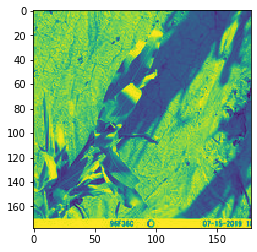

In [102]:
# Get the testing file 
# You can use any file from the testData folder

original_image   = io.imread('images/testData/wheat_1.jpeg',as_gray=True) # load the data in gray scale
plt.imshow(original_image)

**Radius 1**<br> 
**Points 8**

In [116]:
# settings for LBP
radius = 1                # radius of the local binary pattern
point_count = 8 * radius  # Number of points generated 
method = 'uniform'        # Method using for the experiment

# keeping track of divergence
best_divergence = {}

# keeping track of execution time
execution_time = {}

In [104]:
# Make more image sernarios with input image
augmented_images_stack = image_augmentation(original_image)

**Reading label data**

Read the labeled images from the labeledImages folder and store the infromation
in dictionary objects.

In [105]:
# Reading data 
lbp_ref_dictionary,images_ref_dictionary  = loadLabeldata()      

print('Data loaded.')

Data loaded.


**find the image which has the closest ldp texture**

Next we will get the labeled images and augmented images from the images that needs to recognize and match the closest lbp value in each picture. 


In [106]:
# Find the closest class label 
closest_label_name,minimum_distribution = getClosestClass(lbp_ref_dictionary,augmented_images_stack)
print('closest class    : ',closest_label_name)
print('minimum_distribution : ',minimum_distribution)

instance = '1_8'
best_divergence[instance] = minimum_distribution

closest class    :  corn_2
minimum_distribution :  0.0008622997563904945


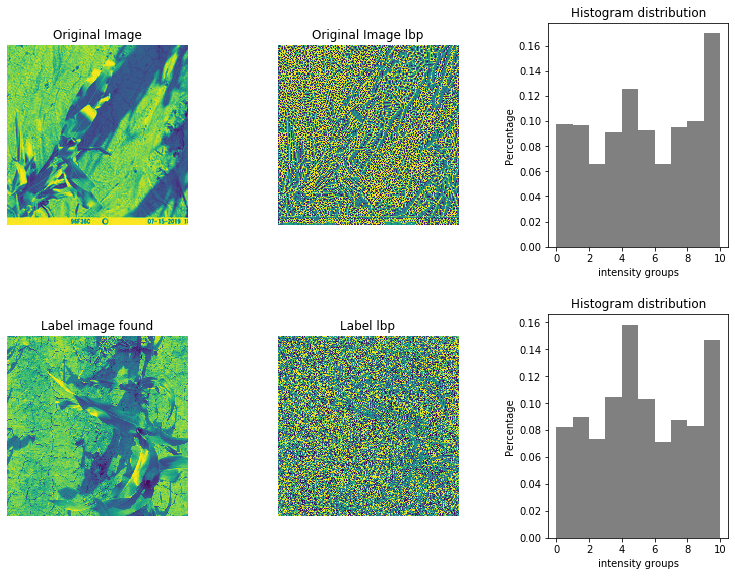

In [107]:
# plot distribution
plotgraphs(original_image,images_ref_dictionary[closest_label_name],point_count, radius, method)

# <i>Divergence and Runtime analysis</i>

Now we can analayse the Divergence, run time and the simulations' ability to identying the correct image via changing the radius of each simulation.
Our main objective is to monitor the simulation reaction to radius changes in lpb. Through out the whole process the method will be set as 'UNIFORM'


First lets start with setting radius to 1.</br>
**Radius 1**<br> 
**Points 8**

Data loaded.
closest class    :  corn_2
minimum_distribution :  0.0008622997563904945


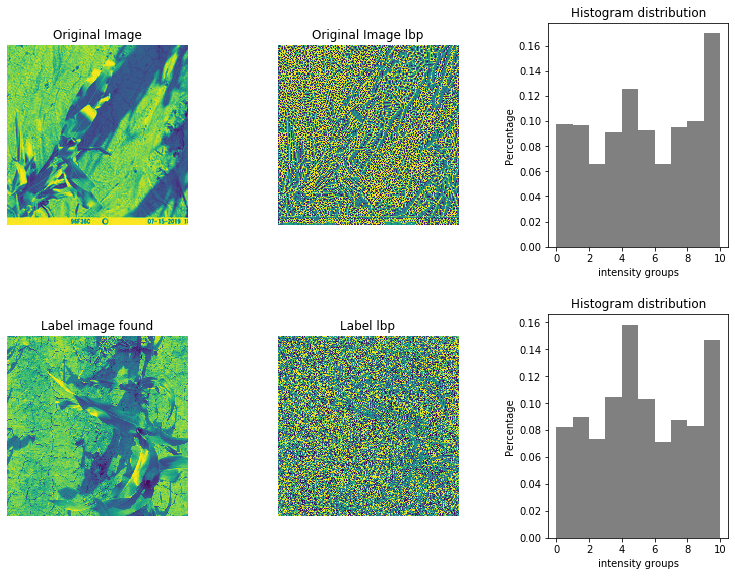

In [108]:
# settings for LBP
radius = 1
point_count = 8 * radius
method = 'uniform'

start_time = time.time() # timer started

# Make more image sernarios with input image
augmented_images_stack = image_augmentation(original_image)

# Reading data            
lbp_ref_dictionary,images_ref_dictionary  = loadLabeldata()      

print('Data loaded.')

# Find the closest class label 
closest_label_name,minimum_distribution = getClosestClass(lbp_ref_dictionary,augmented_images_stack)
print('closest class    : ',closest_label_name)
print('minimum_distribution : ',minimum_distribution)

instance = '1_8'

best_divergence[instance] = minimum_distribution

execution_time[instance] = time.time() - start_time  # timer ended

# plot distribution
plotgraphs(original_image,images_ref_dictionary[closest_label_name],point_count, radius, method)

**Radius 2**<br> 
**Points 16**

Data loaded.
closest class    :  branches_2
minimum_distribution :  0.00323851325685663


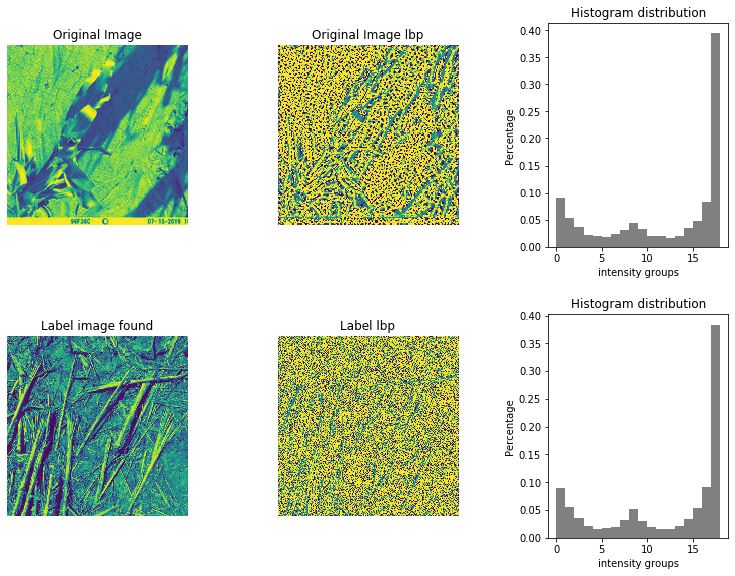

In [109]:
# settings for LBP
radius = 2
point_count = 8 * radius
method = 'uniform'

start_time = time.time() # timer started

# Make more image sernarios with input image
augmented_images_stack = image_augmentation(original_image)

# Reading data            
lbp_ref_dictionary,images_ref_dictionary  = loadLabeldata()      

print('Data loaded.')

# Find the closest class label 
closest_label_name,minimum_distribution = getClosestClass(lbp_ref_dictionary,augmented_images_stack)
print('closest class    : ',closest_label_name)
print('minimum_distribution : ',minimum_distribution)

instance = '2_16'
best_divergence[instance] = minimum_distribution

execution_time[instance] = time.time() - start_time  # timer ended

# plot distribution
plotgraphs(original_image,images_ref_dictionary[closest_label_name],point_count, radius, method)

**Radius 3**<br> 
**Points 24**

Data loaded
closest class    :  cracked_land_1
minimum_distribution :  0.005414648432694425


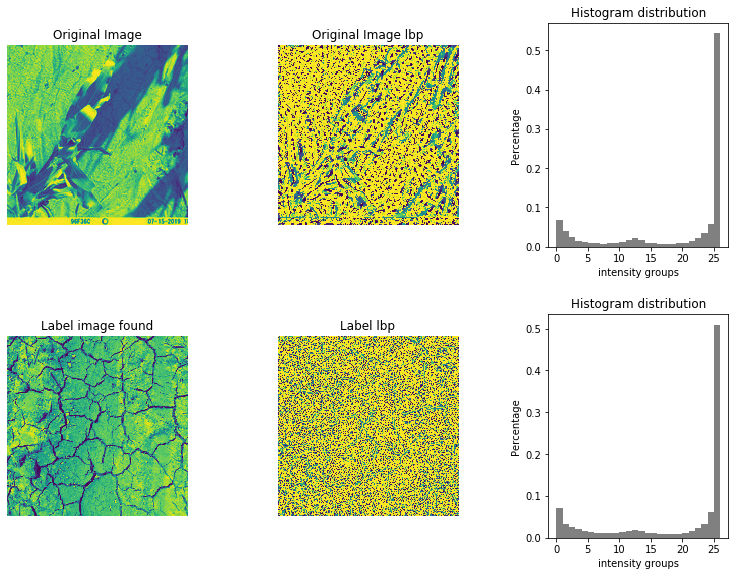

In [110]:
# settings for LBP
radius = 3
point_count = 8 * radius
method = 'uniform'

start_time = time.time() # timer started

# Make more image sernarios with input image
augmented_images_stack = image_augmentation(original_image)

# Reading data            
lbp_ref_dictionary,images_ref_dictionary  = loadLabeldata()      

print('Data loaded')

# Find the closest class label 
closest_label_name,minimum_distribution = getClosestClass(lbp_ref_dictionary,augmented_images_stack)
print('closest class    : ',closest_label_name)
print('minimum_distribution : ',minimum_distribution)

instance = '3_24'
best_divergence[instance] = minimum_distribution

execution_time[instance] = time.time() - start_time  # timer ended

# plot distribution
plotgraphs(original_image,images_ref_dictionary[closest_label_name],point_count, radius, method)

# Divergence 

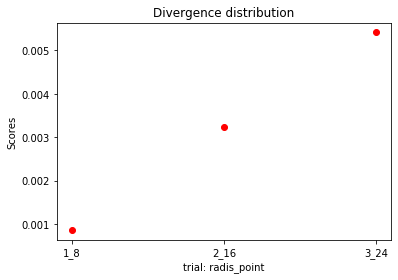

In [111]:
best_score_list = sorted(best_divergence.items()) # sorted by key, return a list of tuples

x, y = zip(*best_score_list) # unpack a list of pairs into two tuples


plt.plot(x, y ,'ro')
plt.title('Divergence distribution')
plt.ylabel('Scores')
plt.xlabel('trial: radis_point')
plt.show()

# Execution times

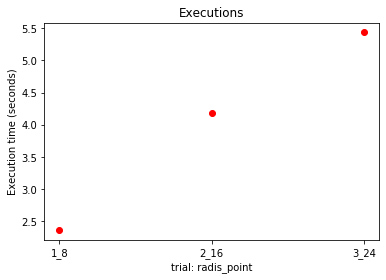

In [114]:
best_score_list = sorted(execution_time.items()) # sorted by key, return a list of tuples

x, y = zip(*best_score_list) # unpack a list of pairs into two tuples

plt.plot(x, y ,'ro')
plt.title('Executions')
plt.ylabel('Execution time (seconds)')
plt.xlabel('trial: radis_point')
plt.show()

# Conclusion

- From the observations we could see the that exection time and divergence scores are propotional to the radius in local binary pattern.
- The accuracy decreases  with the increament of the radius in local binary pattern methodology. 
